# Aggregate demand data spatially and temporally

In [1]:
# imports
import pandas as pd
import geopandas as gpd
import numpy as np

import h3

In [2]:
# variables
VOI_INPUT_FILE_PATH = "../processed_data/voi_demand.pickle"
VOI_OUTPUT_FILE_PATH = "../processed_data/voi_demand_h3.pickle"
VOI_HOURLY_PICKUP_OUTPUT_FILE_PATH = "../processed_data/voi_pickup_demand_h3_hourly.pickle"
VOI_HOURLY_DROPOFF_OUTPUT_FILE_PATH = "../processed_data/voi_dropoff_demand_h3_hourly.pickle"


BOLT_INPUT_FILE_PATH = "../processed_data/bolt_demand.pickle"
BOLT_OUTPUT_FILE_PATH = "../processed_data/bolt_demand_h3.pickle"
BOLT_HOURLY_PICKUP_OUTPUT_FILE_PATH = "../processed_data/bolt_pickup_demand_h3_hourly.pickle"
BOLT_HOURLY_DROPOFF_OUTPUT_FILE_PATH = "../processed_data/bolt_dropoff_demand_h3_hourly.pickle"

GRID_CELLS_LIST_OUTPUT_FILE_PATH = "../processed_data/grid_cells_list.pickle"
GRID_COMMUNITY_MAP_OUTPUT_FILE_PATH = "../processed_data/grid_community_map.pickle"

# resolution 7: area ~ 5 161 293 m2 radius ~ 1406 m
# reosultion 8: area ~ 737 327 m2 radius ~ 530 m
# resolution 9: area ~ 105 332 m2 radius ~ 200 m
H3_RESOLUTION_GRID = 8
H3_RESOLUTION_COMMUNTIY = 6
STUTTGART_BOUNDS = [9.045, 48.7, 9.28, 48.86]
COMMUNITIES_TO_CONSIDER = ['861faa7afffffff', '861faa717ffffff', '861faa71fffffff', '861faa787ffffff', '861faa637ffffff', '861faa44fffffff', '861faa707ffffff', '861faa78fffffff', '861faa7a7ffffff']


In [3]:
voi_input_df = pd.read_pickle(VOI_INPUT_FILE_PATH)
bolt_input_df = pd.read_pickle(BOLT_INPUT_FILE_PATH)

voi_input_size = len(voi_input_df)
bolt_input_size = len(bolt_input_df)

In [4]:
def filter_df(df, bounds):
    """
    Filter the dataframe to only include rows within the specified bounds.
    """
    return df[(df['lon'] >= bounds[0]) & (df['lon'] <= bounds[2]) & 
              (df['lat'] >= bounds[1]) & (df['lat'] <= bounds[3])]

In [5]:
voi_df = filter_df(voi_input_df, STUTTGART_BOUNDS)
bolt_df = filter_df(bolt_input_df, STUTTGART_BOUNDS)

In [6]:
voi_filtered_size = len(voi_df)
bolt_filtered_size = len(bolt_df)
print(f"VOI input size: {voi_input_size}, filtered size: {voi_filtered_size} - {voi_filtered_size/voi_input_size:.2%}")
print(f"Bolt input size: {bolt_input_size}, filtered size: {bolt_filtered_size} - {bolt_filtered_size/bolt_input_size:.2%}")

VOI input size: 2168331, filtered size: 876511 - 40.42%
Bolt input size: 680459, filtered size: 656082 - 96.42%


In [7]:
def add_h3_indicies(df):
    df["geometry"] = gpd.points_from_xy(df["lon"], df["lat"], crs="EPSG:4326")
    df["grid_index"] = df.apply(
        lambda x: h3.latlng_to_cell(x["lat"], x["lon"], H3_RESOLUTION_GRID), axis=1
    )
    df["community_index"] = df.apply(
        lambda x: h3.cell_to_parent(x["grid_index"], H3_RESOLUTION_COMMUNTIY), axis=1
    )
    # timestamp as mean of start range and end range
    df["timestamp"] = pd.to_datetime(
        (
            df["event_time_start_range"].view(np.int64)
            + df["event_time_end_range"].view(np.int64)
        )
        // 2
    )
    df.drop(columns=["event_time_start_range", "event_time_end_range"], inplace=True)
    df.drop(columns=["lon", "lat"], inplace=True)
    df.set_index("timestamp", inplace=True)
    return df

In [8]:
voi_df = add_h3_indicies(voi_df)
bolt_df = add_h3_indicies(bolt_df)

/tmp/ipykernel_27010/1191234004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["geometry"] = gpd.points_from_xy(df["lon"], df["lat"], crs="EPSG:4326")
/tmp/ipykernel_27010/1191234004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["grid_index"] = df.apply(
/tmp/ipykernel_27010/1191234004.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [9]:
voi_df.head()

,bike_id,current_range_meters,current_fuel_percent,event_type,geometry,grid_index,community_index
timestamp,,,,,,,
2025-02-11 14:57:35,VOJ:Vehicle:ed086d78-6194-4a8b-a37c-390f1f07533c,69600.0,None,pickup,POINT (9.23589 48.81528),881faa7181fffff,861faa71fffffff
2025-02-11 14:57:35,VOJ:Vehicle:e1b69fc3-bf67-4eb8-a091-f2bc178d2f8d,76000.0,None,pickup,POINT (9.15024 48.81025),881faa713dfffff,861faa717ffffff
2025-02-11 14:57:35,VOJ:Vehicle:f1339d7c-0637-4a19-957d-fab5a843bda0,59200.0,None,pickup,POINT (9.16081 48.77264),881faa7a8dfffff,861faa7afffffff
2025-02-11 14:57:35,VOJ:Vehicle:149ddb57-a0b6-4bd2-a77a-aebb2132abfd,51200.0,None,pickup,POINT (9.15595 48.81764),881faa7107fffff,861faa717ffffff
2025-02-11 14:57:35,VOJ:Vehicle:2030e8bd-f73f-454a-9065-c129a5ec6ca9,76000.0,None,pickup,POINT (9.10643 48.72325),881faa782bfffff,861faa787ffffff


In [10]:
bolt_df.head()

,bike_id,current_range_meters,current_fuel_percent,event_type,geometry,grid_index,community_index
timestamp,,,,,,,
2025-02-11 14:42:07,BLT:Vehicle:740666c5-38af-4cd9-8ea8-d7a4b623294b,23800.0,0.44,pickup,POINT (9.23838 48.82612),881faa718bfffff,861faa71fffffff
2025-02-11 14:42:07,BLT:Vehicle:c736bf7f-9e1b-40df-af6c-afb04271040e,22400.0,0.42,pickup,POINT (9.07409 48.74804),881faa7b13fffff,861faa7b7ffffff
2025-02-11 14:42:07,BLT:Vehicle:f7b43738-0836-4443-9d7a-723976f84870,14000.0,0.30,pickup,POINT (9.18369 48.80967),881faa7133fffff,861faa717ffffff
2025-02-11 14:42:07,BLT:Vehicle:50f1520d-feea-47e2-afb3-56ec8064d9b5,46900.0,0.77,pickup,POINT (9.16575 48.74136),881faa78cdfffff,861faa78fffffff
2025-02-11 14:42:07,BLT:Vehicle:e1c6c470-1032-4ea6-94b6-e69de8492a97,35000.0,0.60,pickup,POINT (9.18678 48.78089),881faa7a8bfffff,861faa7afffffff


In [11]:
# filter the dataframes to only include the communities we are interested in
print(f"Number of rows in VOI DataFrame before filtering: {len(voi_df)}")
print(f"Number of rows in BOLT DataFrame before filtering: {len(bolt_df)}")


voi_df = voi_df[voi_df["community_index"].isin(COMMUNITIES_TO_CONSIDER)]
bolt_df = bolt_df[bolt_df["community_index"].isin(COMMUNITIES_TO_CONSIDER)]

print(f"Number of rows in VOI DataFrame after filtering: {len(voi_df)}")
print(f"Number of rows in BOLT DataFrame after filtering: {len(bolt_df)}")

print(f"Number of community indices in VOI DataFrame: {voi_df['community_index'].nunique()}")
print(f"Number of community indices in BOLT DataFrame: {bolt_df['community_index'].nunique()}")

print(f"Number of grid indices in VOI DataFrame: {voi_df['grid_index'].nunique()}")
print(f"Number of grid indices in BOLT DataFrame: {bolt_df['grid_index'].nunique()}")

Number of rows in VOI DataFrame before filtering: 876511
Number of rows in BOLT DataFrame before filtering: 656082
Number of rows in VOI DataFrame after filtering: 876301
Number of rows in BOLT DataFrame after filtering: 655798
Number of community indices in VOI DataFrame: 9
Number of community indices in BOLT DataFrame: 9
Number of grid indices in VOI DataFrame: 250
Number of grid indices in BOLT DataFrame: 251


In [12]:
# align the columns of the two dataframes
voi_columns = voi_df.grid_index.unique() 
bolt_columns = bolt_df.grid_index.unique()

intersection = list(set(voi_columns) & set(bolt_columns))
only_in_voj = list(set(voi_columns) - set(bolt_columns))
only_in_bolt = list(set(bolt_columns) - set(voi_columns))
all_columns = sorted(list(set(voi_columns) | set(bolt_columns)))
print("Total grid cells: ", len(all_columns))
print("Columns in both dataframes: ", len(intersection))
print("Columns only in VOI dataframe: ", len(only_in_voj))
print("Columns only in BOLT dataframe: ", len(only_in_bolt))

Total grid cells:  291
Columns in both dataframes:  210
Columns only in VOI dataframe:  40
Columns only in BOLT dataframe:  41


In [13]:
# save the dataframes to pickle files
voi_df.to_pickle(VOI_OUTPUT_FILE_PATH)
bolt_df.to_pickle(BOLT_OUTPUT_FILE_PATH)

In [14]:
grid_cells_df = pd.DataFrame(all_columns, columns=["grid_index"])
grid_cells_df["geometry"] = grid_cells_df.apply(
    lambda x: h3.cell_to_boundary(x["grid_index"]), axis=1
)
grid_cells_df.to_pickle(GRID_CELLS_LIST_OUTPUT_FILE_PATH)    
grid_cells_df.head()

,grid_index,geometry
0,881faa4485fffff,"((48.833396536059425, 9.050864230899897), (48...."
1,881faa4487fffff,"((48.83200932584397, 9.062893592658527), (48.8..."
2,881faa4493fffff,"((48.84129862635126, 9.10439595805226), (48.83..."
3,881faa4497fffff,"((48.83526513835251, 9.095673690358426), (48.8..."
4,881faa4499fffff,"((48.8501136325176, 9.089052104897382), (48.84..."


In [15]:
grid_commmunity_map_df = pd.DataFrame(all_columns, columns=["grid_index"])
grid_commmunity_map_df["community_index"] = grid_commmunity_map_df.apply(
    lambda x: h3.cell_to_parent(x["grid_index"], H3_RESOLUTION_COMMUNTIY), axis=1
)
grid_commmunity_map_df = grid_commmunity_map_df[grid_commmunity_map_df["community_index"].isin(COMMUNITIES_TO_CONSIDER)]
grid_commmunity_map_df.to_pickle(GRID_COMMUNITY_MAP_OUTPUT_FILE_PATH)
grid_commmunity_map_df.head()

,grid_index,community_index
0,881faa4485fffff,861faa44fffffff
1,881faa4487fffff,861faa44fffffff
2,881faa4493fffff,861faa44fffffff
3,881faa4497fffff,861faa44fffffff
4,881faa4499fffff,861faa44fffffff


In [16]:
grid_commmunity_map_df["community_index"].unique(), grid_commmunity_map_df["community_index"].nunique(), len(grid_commmunity_map_df)

(array(['861faa44fffffff', '861faa637ffffff', '861faa707ffffff',
        '861faa717ffffff', '861faa71fffffff', '861faa787ffffff',
        '861faa78fffffff', '861faa7a7ffffff', '861faa7afffffff'],
       dtype=object),
 9,
 291)

In [17]:
# group by grid index and sum the demand hourly
def group_by_hour(df):
    grouped_df = df.resample('h').grid_index.value_counts().unstack().fillna(0)
    # add mising columns
    for col in all_columns:
        if col not in grouped_df.columns:
            grouped_df[col] = 0
    
    # reorder columns
    grouped_df = grouped_df[all_columns]
    return grouped_df
    

In [18]:
voi_pickup_df = group_by_hour(voi_df[voi_df["event_type"] == "pickup"])
voi_dropoff_df = group_by_hour(voi_df[voi_df["event_type"] == "dropoff"])

bolt_pickup_df = group_by_hour(bolt_df[bolt_df["event_type"] == "pickup"])
bolt_dropoff_df = group_by_hour(bolt_df[bolt_df["event_type"] == "dropoff"])

In [19]:
voi_dropoff_df.head()

grid_index,881faa4485fffff,881faa4487fffff,881faa4493fffff,881faa4497fffff,881faa4499fffff,881faa449bfffff,881faa44a3fffff,881faa44a7fffff,881faa44abfffff,881faa44b1fffff,...,881faa7ad9fffff,881faa7adbfffff,881faa7addfffff,881faa7ae1fffff,881faa7ae3fffff,881faa7ae5fffff,881faa7ae7fffff,881faa7ae9fffff,881faa7aebfffff,881faa7aedfffff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2025-02-11 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2025-02-11 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0
2025-02-11 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0
2025-02-11 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0


In [20]:
bolt_dropoff_df.head()

grid_index,881faa4485fffff,881faa4487fffff,881faa4493fffff,881faa4497fffff,881faa4499fffff,881faa449bfffff,881faa44a3fffff,881faa44a7fffff,881faa44abfffff,881faa44b1fffff,...,881faa7ad9fffff,881faa7adbfffff,881faa7addfffff,881faa7ae1fffff,881faa7ae3fffff,881faa7ae5fffff,881faa7ae7fffff,881faa7ae9fffff,881faa7aebfffff,881faa7aedfffff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 14:00:00,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2025-02-11 15:00:00,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0
2025-02-11 16:00:00,0,0,0,0,0,0,0,0,0,0,...,1.0,2.0,3.0,2.0,3.0,0.0,0.0,0.0,2.0,0.0
2025-02-11 17:00:00,0,0,0,0,0,0,0,0,0,0,...,1.0,1.0,2.0,2.0,2.0,0.0,0.0,1.0,3.0,0.0
2025-02-11 18:00:00,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,1.0,3.0,0.0,0.0,1.0,2.0,0.0


In [21]:
len(voi_pickup_df.columns), len(bolt_pickup_df.columns), len(voi_dropoff_df.columns), len(bolt_dropoff_df.columns)

(291, 291, 291, 291)

In [22]:
# Save the dataframes to pickle files
voi_pickup_df.to_pickle(VOI_HOURLY_PICKUP_OUTPUT_FILE_PATH)
voi_dropoff_df.to_pickle(VOI_HOURLY_DROPOFF_OUTPUT_FILE_PATH)

bolt_pickup_df.to_pickle(BOLT_HOURLY_PICKUP_OUTPUT_FILE_PATH)
bolt_dropoff_df.to_pickle(BOLT_HOURLY_DROPOFF_OUTPUT_FILE_PATH)

In [23]:
bolt_pickup_df.index[0], bolt_pickup_df.index[-1]

(Timestamp('2025-02-11 14:00:00'), Timestamp('2025-06-18 15:00:00'))

In [24]:
len(voi_pickup_df), len(voi_dropoff_df), len(bolt_pickup_df), len(bolt_dropoff_df)

(2978, 2978, 3023, 3023)

In [25]:
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Polygon

def create_map(df_filtered: pd.DataFrame,
                               df_all: pd.DataFrame,
                               bounding_box: list,
                               output_filename: str = "provider_filtering_subplots.png"):

    min_lon, min_lat, max_lon, max_lat = bounding_box
    bbox_polygon = Polygon([
        (min_lon, min_lat), (max_lon, min_lat),
        (max_lon, max_lat), (min_lon, max_lat),
        (min_lon, min_lat)
    ])
    boundary_gdf = gpd.GeoDataFrame([1], geometry=[bbox_polygon], crs="EPSG:4326")
    boundary_gdf_proj = boundary_gdf.to_crs(epsg=3857)

    fig, axs = plt.subplots(1, 1, figsize=(20, 10), sharex=True, sharey=True)

    all_gdf_proj = gpd.GeoDataFrame(
        df_all, geometry='geometry', crs="EPSG:4326"
    ).to_crs(epsg=3857)

    filtered_gdf_proj = gpd.GeoDataFrame(
        df_filtered, geometry='geometry', crs="EPSG:4326"
    ).to_crs(epsg=3857)

    boundary_gdf_proj.plot(ax=axs, facecolor='none', edgecolor='#b6163d', linewidth=2, zorder=3)
    all_gdf_proj.plot(ax=axs, marker='o', color='#5e6e8a', markersize=8, alpha=0.4, zorder=1)
    filtered_gdf_proj.plot(ax=axs, marker='o', color='#193058', markersize=10, alpha=0.7, zorder=2)

    cx.add_basemap(axs, source=cx.providers.CartoDB.Positron)
    axs.set_axis_off()

    plt.savefig(output_filename, dpi=300, bbox_inches='tight')

In [26]:
voi_input_df["geometry"] = gpd.points_from_xy(voi_input_df["lon"], voi_input_df["lat"], crs="EPSG:4326")
voi_input_df = filter_df(voi_input_df, [7.357321,47.408152,10.444479,49.595177])
bolt_input_df["geometry"] = gpd.points_from_xy(bolt_input_df["lon"], bolt_input_df["lat"], crs="EPSG:4326")

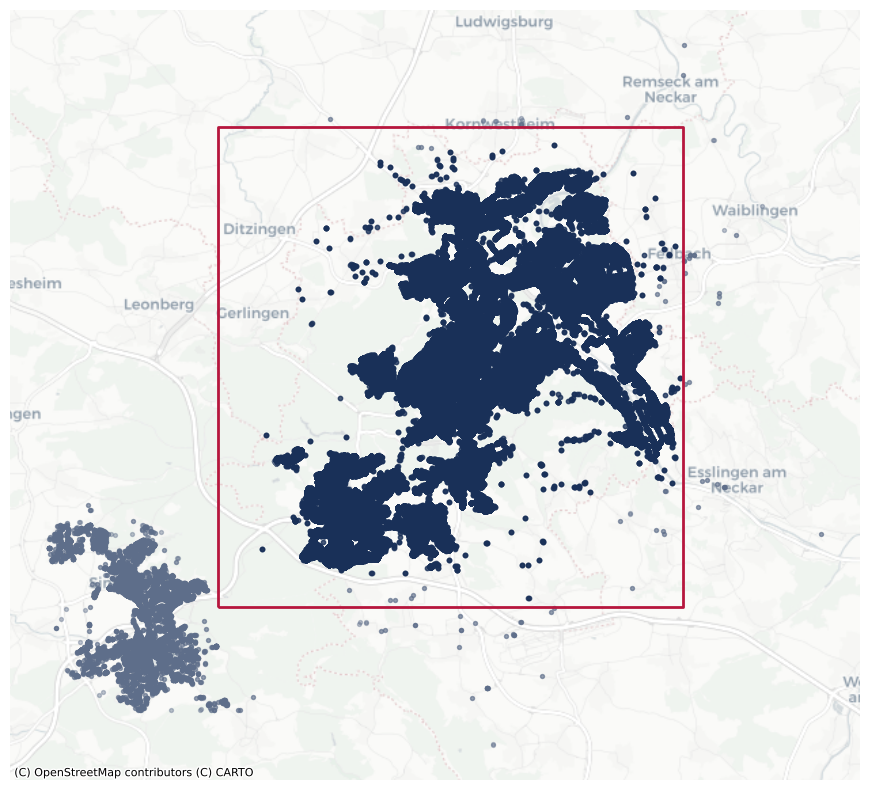

In [27]:
create_map(
    df_all=bolt_input_df,
    df_filtered=bolt_df,
    bounding_box=STUTTGART_BOUNDS,
    output_filename="../figures/bolt_filtering_subplots.png"
)

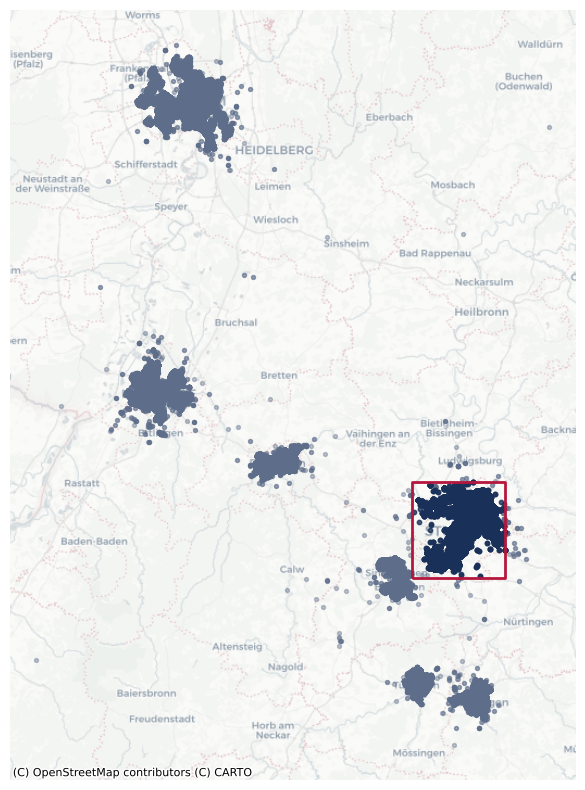

In [28]:
create_map(
    df_all=voi_input_df,
    df_filtered=voi_df,
    bounding_box=STUTTGART_BOUNDS,
    output_filename="../figures/voi_filtering_subplots.png"
)

## General Statistics

In [29]:
full_demand_df = pd.concat([voi_df, bolt_df], axis=0)
full_demand_df.head()

/tmp/ipykernel_27010/3206607369.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_demand_df = pd.concat([voi_df, bolt_df], axis=0)


,bike_id,current_range_meters,current_fuel_percent,event_type,geometry,grid_index,community_index
timestamp,,,,,,,
2025-02-11 14:57:35,VOJ:Vehicle:ed086d78-6194-4a8b-a37c-390f1f07533c,69600.0,NaN,pickup,POINT (9.23589 48.81528),881faa7181fffff,861faa71fffffff
2025-02-11 14:57:35,VOJ:Vehicle:e1b69fc3-bf67-4eb8-a091-f2bc178d2f8d,76000.0,NaN,pickup,POINT (9.15024 48.81025),881faa713dfffff,861faa717ffffff
2025-02-11 14:57:35,VOJ:Vehicle:f1339d7c-0637-4a19-957d-fab5a843bda0,59200.0,NaN,pickup,POINT (9.16081 48.77264),881faa7a8dfffff,861faa7afffffff
2025-02-11 14:57:35,VOJ:Vehicle:149ddb57-a0b6-4bd2-a77a-aebb2132abfd,51200.0,NaN,pickup,POINT (9.15595 48.81764),881faa7107fffff,861faa717ffffff
2025-02-11 14:57:35,VOJ:Vehicle:2030e8bd-f73f-454a-9065-c129a5ec6ca9,76000.0,NaN,pickup,POINT (9.10643 48.72325),881faa782bfffff,861faa787ffffff


In [30]:
full_demand_df.groupby(full_demand_df.index.hour).size().sort_values(ascending=False).head(1)

timestamp
15    110775
dtype: int64

In [31]:
# average demand per day
full_demand_df.groupby(full_demand_df.index.date).size().mean()

11969.5234375

In [32]:
# total number of pickups and dropoffs
total_pickups = full_demand_df[full_demand_df["event_type"] == "pickup"].shape[0]
total_dropoffs = full_demand_df[full_demand_df["event_type"] == "dropoff"].shape[0]
print(f"Total pickups: {total_pickups}, Total dropoffs: {total_dropoffs}")

Total pickups: 765878, Total dropoffs: 766221
